# Machine Learning : HW3

In [1]:
import random
import numpy as np
import pandas as pd
from typing import List
from collections import Counter
from utils_svm_reviews import *
from datetime import datetime
from matplotlib import pyplot as plt
from typing import List, Dict

## Data and Sparse Representation (Q6 - Q12)

### Load Data

In [2]:
# Utils
def get_bag_of_words(words):
    return Counter(words)

def normalize(arr):
    min_val, max_val = min(arr), max(arr)
    return [(val - min_val) / (max_val - min_val) for val in arr]

# Load Data
data = load_and_shuffle_data()
data = [(get_bag_of_words(line[:-1]), line[-1]) for line in data]

# # Preprocessing
# feature_map = {}
# for i, row in enumerate(data):
#     x_features = row[0]
#     for k, v in x_features.items():
#         f_map = feature_map.get(k, [])
#         if not f_map:
#             f_map = [0 for _ in range(i)]  # Add 0s for rows yet without this feature
        
#         f_map.append(v)
#         feature_map[k] = f_map
        
#     miss_features = [k for k in feature_map.keys() if k not in x_features.keys()]
#     for key in miss_features:
#         feature_map[key].append(0)  # Add 0s for keys not included in this row

# feature_map = {k: normalize(v) for k, v in feature_map.items()}
# data_normalized = []
# for i, row in enumerate(data):
#     x_features = row[0]
#     for k, v in x_features.items():
#         x_features[k] = feature_map[k][i]
    
#     data_normalized.append((x_features, row[1]))



X_train, y_train = [rev[0] for rev in data[:1500]], [rev[1] for rev in data[:1500]]
X_test, y_test = [rev[0] for rev in data[1500:]], [rev[1] for rev in data[1500:]]

In [3]:
# Pegasos Algorithm
def train_pegasos(x: List[dict], y: List[int], lam: float, epochs: int = 2, seed: bool = False) -> dict:
    """Train weights corresponding to training data represented as sparse matrix.

    Args:
        x: Training features
        y: Training output class
        lam: Regularization factor
        epochs: Number of epochs to run
        seed: Whether or not to seed the shuffles

    Returns:
        Sparse matrix of trained weights.
    """
    seeds, w, xy, t= list(range(epochs)), {}, list(zip(x, y)), 2
    print("Naive Pegasos SGD")
    for j in range(epochs):
        print(f"Epoch: {j}")
        if seed:
            random.seed(j)
        xy_shuffled = random.sample(xy, k=len(xy))
        x_train, y_train = [r[0] for r in xy_shuffled], [r[1] for r in xy_shuffled]
        for i in range(len(x)):
            eta = 1.0 / (t * lam)
            margin = y_train[i] * dotProduct(w, x_train[i])
            scale = (1.0 - eta * lam)

            for k, v, in w.items():
                w[k] = v*scale

            if margin < 1.0:
                increment(w, eta * y_train[i], x_train[i])
                
            t += 1

    return w


def train_pegasos_opt(x: List[dict], y: List[int], lam: float, epochs: int = 2, seed: bool = False) -> dict:
    """Train weights corresponding to training data represented as sparse matrix.

    Args:
        x: Training features
        y: Training output class
        lam: Regularization factor
        epochs: Number of epochs to run
        seed: Whether or not to seed the shuffles

    Returns:
        Sparse matrix of trained weights.
    """
    seeds, s, w, xy, t= list(range(epochs)), 1.0, {}, list(zip(x, y)), 2
    print("Optimized Pegasos SGD")
    for j in range(epochs):
        print(f"Epoch: {j}")
        if seed:
            random.seed(j)
        xy_shuffled = random.sample(xy, k=len(xy))
        x_train, y_train = [r[0] for r in xy_shuffled], [r[1] for r in xy_shuffled]
        for i in range(len(x_train)):
            eta = 1.0 / (t * lam)

            margin = y_train[i] * dotProduct(w, x_train[i])
            miss = margin < (1.0 / s)
            s *= (1.0 - eta * lam)

            if miss:
                increment(w, (eta / s) * y_train[i], x_train[i])
            
            t += 1

    return {k: s * v for k, v in w.items()}

### Naive vs Optimized Pegasos Variants (Q10)

In [4]:
# Performance Evaluation
n_epoch, lam_coeff = 4, 0.01

start = datetime.now()
w1 = train_pegasos(X_train, y_train, lam_coeff, epochs=n_epoch, seed=True)
end = datetime.now()
print(f"Naive Pegasos Runtime: {(end - start).microseconds} microseconds\n")

start = datetime.now()
w2 = train_pegasos_opt(X_train, y_train, lam_coeff, epochs=n_epoch, seed=True)
end = datetime.now()
print(f"Optimized Pegasos Runtime: {(end - start).microseconds} microseconds")

Naive Pegasos SGD
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Naive Pegasos Runtime: 558482 microseconds

Optimized Pegasos SGD
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Optimized Pegasos Runtime: 311511 microseconds


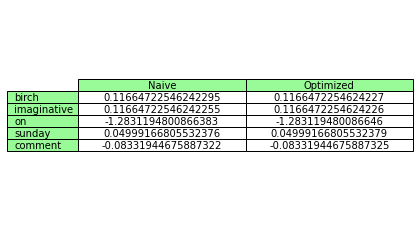

In [5]:
# Verification
sample_keys = ["birch", "imaginative", "on", "sunday", "comment"]
naive_samples = [w1[k] for k in sample_keys]
optimized_samples = [w2[k] for k in sample_keys]

w_pairs = list(zip(naive_samples, optimized_samples))

fig, ax = plt.subplots()
ax.set_axis_off()
table = ax.table(
        cellText=w_pairs,
        rowLabels=sample_keys,
        colLabels=["Naive", "Optimized"],
        rowColours=["palegreen"] * 10,
        colColours=["palegreen"] * 10,
        cellLoc="center",
        loc="center",
    )
fig.savefig("naive_vs_opt_pegasos.pdf", bbox_inches='tight')

In [6]:
# Calculate error
def classification_error(x: List[dict], w: Dict[str, float], y: List[int]) -> float:
    """Calculate 0-1 loss for given data and weights.

    Args:
        x: Feature vector
        w: weights
        y: Output labels

    Returns:
        0-1 loss error
    """
    incorrect = 0.0
    for i, x_vec in enumerate(x):
        pred = dotProduct(w, x_vec)
        if np.sign(pred) != y[i]:
            incorrect += 1

    return incorrect / len(x)

def predict(x, w):
    predictions = []
    for i, x_vec in enumerate(x):
        predictions.append(np.sign(dotProduct(w, x_vec)))
    
    return predictions

classification_error(X_test, w2, y_test)

0.178

### Tune Regularization Parameter Q(12)

Optimized Pegasos SGD
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Optimized Pegasos SGD
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch:

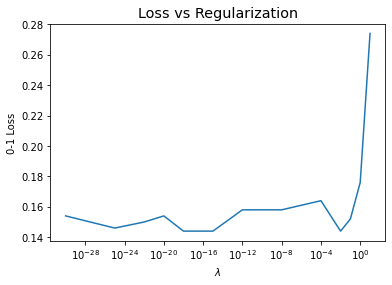

In [14]:
n_epochs, lams = 50, [10**-30, 10**-25, 10**-22, 10**-20, 10**-18, 10**-15, 10**-12, 10**-8, 10**-4, 10**-2, 0.1, 1, 10]
losses = []
for lam in lams:
    w = train_pegasos_opt(X_train, y_train, lam=lam, epochs=n_epochs)
    losses.append(classification_error(X_test, w, y_test))

print(lams)
print(losses)
plt.plot(lams, losses)
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("0-1 Loss")
plt.title("Loss vs Regularization", fontsize="x-large")
# plt.savefig("pegasos_opt_lambda.pdf")

### Error Analysis (Q12-13)

In [8]:
def get_score(x, w):
    return {f: abs(x.get(f, 0) * v) for f, v in w.items()}

# Predict
lam = 0.01
w = train_pegasos_opt(X_train, y_train, lam=lam, epochs=n_epochs)
predictions = predict(X_test, w)

Optimized Pegasos SGD
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


In [9]:
# Split into groups
import math
num_groups, test_scores = 10, []
for i, x_vec in enumerate(X_test):
    test_scores.append((i, dotProduct(w, x_vec)))
test_scores = [(s[0], abs(s[1]), np.sign(s[1])) for s in test_scores]
test_scores = sorted(test_scores, key=lambda a: a[1])

group_size = math.ceil(len(test_scores) / num_groups)
score_groups = [test_scores[i : i + group_size] for i in range(0, len(test_scores) - group_size + 1, group_size)]

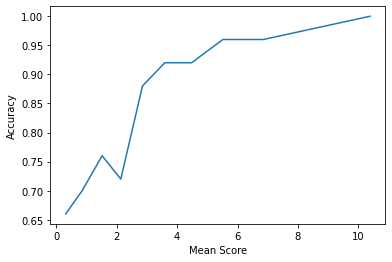

In [10]:
mean_scores, accuracy = [], []
for grp in score_groups:
    tot_score, correct = 0, 0
    for entry in grp:
        i, score, prediction = entry
        tot_score += score
        if prediction == y_test[i]:
            correct += 1
    mean_scores.append(tot_score / len(grp))
    accuracy.append(correct / len(grp))
    
plt.plot(mean_scores, accuracy)
plt.xlabel("Mean Score")
plt.ylabel("Accuracy")
plt.savefig("score_vs_accuracy.pdf")

In [11]:
incorrect_idx = [i for i in range(len(X_test)) if predictions[i] != y_test[i]]
print(len(incorrect_idx))

76


#### Analyze Incorrect Samples

53 365


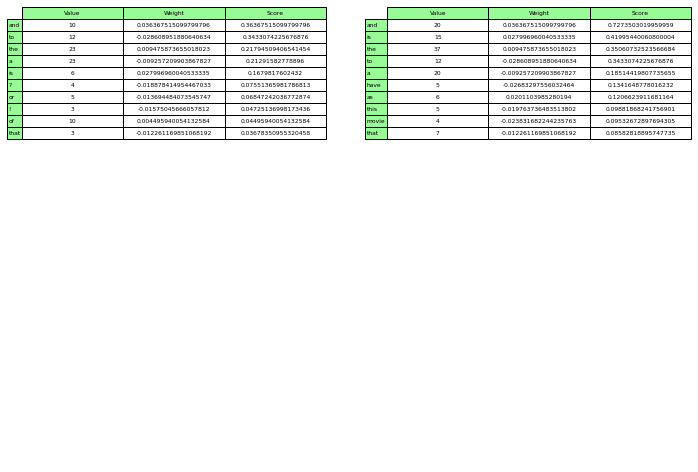

In [25]:
# Incorrect examples
i, j = np.random.choice(incorrect_idx, size=2)
print(i, j)
s1, s2 = X_test[i], X_test[j]

# Investigate samples
s1_scores = get_score(w, s1)
top_10_features_s1 = sorted(s1_scores.items(), key=lambda x: x[1], reverse=True)[:10]
score_weights_s1 = [(s1[feature], w[feature], score) for feature, score in top_10_features_s1]

s2_scores = get_score(w, s2)
top_10_features_s2 = sorted(s2_scores.items(), key=lambda x: x[1], reverse=True)[:10]
score_weights_s2 = [(s2[feature], w[feature], score) for feature, score in top_10_features_s2]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_axis_off()
s1_top_f_table = ax[0].table(
        cellText=score_weights_s1,
        rowLabels=[f[0] for f in top_10_features_s1],
        colLabels=["Value", "Weight", "Score"],
        rowColours=["palegreen"] * 10,
        colColours=["palegreen"] * 10,
        cellLoc="center",
        loc="top",
    )

ax[1].set_axis_off()
s1_top_f_table = ax[1].table(
        cellText=score_weights_s2,
        rowLabels=[f[0] for f in top_10_features_s2],
        colLabels=["Value", "Weight", "Score"],
        rowColours=["palegreen"] * 10,
        colColours=["palegreen"] * 10,
        cellLoc="center",
        loc="top",
    )
fig.savefig("top_10_incorrect_features.pdf", bbox_inches='tight')

## Kernels (Q21 - Q28)
### Kernel Machines